# Computing standard deviation on 4-day time windows of ROMS state variables (zeta, u, ...)

Steps:

1. Load 3D history files
2. Subset by time to get the model run window (e.g. a few months)

For each variable:
    
3. Lowpass filter (for 3D variables, do layer-by-layer)
4. Compute std on 6-day window with 1-day overlap (4+2) of the lowpass filtered data
5. Save std to file

SEe also `compute_std_forcing_qck.py`

In [2]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [3]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(16)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.64:42724 Dashboard: http://146.118.38.64:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
import numpy as np
from os import system as sys

import xarray as xr
import pandas as pd
import dask
import glob
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
# Step 1: Load 3D variable
roms = xr.open_mfdataset('../ROMSdata/outputs/roms_nws_*his.nc', concat_dim='ocean_time')
roms

KeyboardInterrupt: 

In [ ]:
# Step 2: Subset by time
# Skip this...
roms.ocean_time[0], roms.ocean_time[-1]

myroms = roms.sel(ocean_time=slice('2017-01-15','2017-06-01'))#.chunk({'ocean_time':-1,'eta_rho':1,'xi_rho':1})
myroms

In [ ]:
def filt(ytmp, cutoff_dt, dt, btype='low', order=3, axis=0 ):
    """
    Butterworth filter the time series
    Inputs:
        cutoff_dt - cuttoff period [seconds]
        btype - 'low' or 'high' or 'band'
    """
    if not btype == 'band':
        Wn = dt/cutoff_dt
    else:
        Wn = [dt/co for co in cutoff_dt]
    
    #(b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba', fs=1)
    
    #return signal.filtfilt(b, a, ytmp, axis=axis, padlen=0)
    print(ytmp.shape, dt, cutoff_dt)
    sos = signal.butter(order, Wn, btype=btype, analog=0, output='sos', fs=1)
    
    return signal.sosfiltfilt(sos, ytmp, axis=axis, padlen=0)

In [ ]:
def filter_roms_2d(roms, varname, cutoff_dt, dt):

    arr = roms[varname].chunk({'ocean_time':-1,'eta_rho':10,'xi_rho':10})

    # Compute the filted variable
    arr_filt = xr.apply_ufunc(filt,
                              arr, cutoff_dt, dt,
                              dask='parallelized',
                              #dask='allowed',
                              output_dtypes=[arr.dtype],
                              kwargs={'axis': 0, 'order':8}
                             )

    return arr_filt

In [ ]:
# Step 3: Filter

#########
# Variables
cutoff_dt = 34*3600.0
varname = 'zeta'
#########


dt = myroms.ocean_time[1] - myroms.ocean_time[0]
dtsec = dt.values.astype(float)*1e-9

zeta_f = filter_roms_2d(myroms, 'zeta', cutoff_dt, dtsec)
zeta_fp = zeta_f.persist()
#zeta_fp = zeta_f.compute()

In [ ]:
# Important test step...
#plt.figure()
#filt(myroms['zeta'], cutoff_dt, dtsec)
plt.figure()
myroms['zeta'][:,200,500].plot()
zeta_fp[:, 200,500].plot()


In [48]:
# Step 4: Compute the STD on 4+2 windows
#zeta_f_std = zeta_f.rolling(ocean_time=48).construct('stdtime',stride=32)
#zeta_f_std 

In [49]:
times = pd.date_range('2017-02-01','2017-06-01', freq='4D')
times

DatetimeIndex(['2017-02-01', '2017-02-05', '2017-02-09', '2017-02-13',
               '2017-02-17', '2017-02-21', '2017-02-25', '2017-03-01',
               '2017-03-05', '2017-03-09', '2017-03-13', '2017-03-17',
               '2017-03-21', '2017-03-25', '2017-03-29', '2017-04-02',
               '2017-04-06', '2017-04-10', '2017-04-14', '2017-04-18',
               '2017-04-22', '2017-04-26', '2017-04-30', '2017-05-04',
               '2017-05-08', '2017-05-12', '2017-05-16', '2017-05-20',
               '2017-05-24', '2017-05-28', '2017-06-01'],
              dtype='datetime64[ns]', freq='4D')

In [59]:
# Step 5: Save to "std" format file

# Create a file from template
infile = 'std_i_template.nc'
dsin = xr.open_dataset(infile)

# Create an output file
for t1 in times[0:-1]:

    daysince2000 = (t1-np.datetime64('2000-01-01')).total_seconds()/86400

    outfile = '../DATA/std_i_{}.nc'.format(int(daysince2000))

    dsin.to_netcdf(outfile)
    print(outfile)

../DATA/std_i_6241.nc
../DATA/std_i_6245.nc
../DATA/std_i_6249.nc
../DATA/std_i_6253.nc
../DATA/std_i_6257.nc
../DATA/std_i_6261.nc
../DATA/std_i_6265.nc
../DATA/std_i_6269.nc
../DATA/std_i_6273.nc
../DATA/std_i_6277.nc
../DATA/std_i_6281.nc
../DATA/std_i_6285.nc
../DATA/std_i_6289.nc
../DATA/std_i_6293.nc
../DATA/std_i_6297.nc
../DATA/std_i_6301.nc
../DATA/std_i_6305.nc
../DATA/std_i_6309.nc
../DATA/std_i_6313.nc
../DATA/std_i_6317.nc
../DATA/std_i_6321.nc
../DATA/std_i_6325.nc
../DATA/std_i_6329.nc
../DATA/std_i_6333.nc
../DATA/std_i_6337.nc
../DATA/std_i_6341.nc
../DATA/std_i_6345.nc
../DATA/std_i_6349.nc
../DATA/std_i_6353.nc
../DATA/std_i_6357.nc


In [61]:
nc.close()

In [60]:
# Loop through and save all of the data to the file
for t1 in times[0:-1]:

    daysince2000 = (t1-np.datetime64('2000-01-01')).total_seconds()/86400

    outfile = '../DATA/std_i_{}.nc'.format(int(daysince2000))
    print('Saving {} for step {}'.format(varname,t1))

    zeta_f_time = zeta_fp.sel(ocean_time = slice(t1-np.timedelta64(1,'D'), t1+np.timedelta64(5,'D'))).std(axis=0, keepdims=True)

    nc = Dataset(outfile, mode='r+')
    nc['ocean_time'][0] = daysince2000
    nc['zeta'][:] = zeta_f_time

    nc.close()



Saving zeta for step 2017-02-01 00:00:00
Saving zeta for step 2017-02-05 00:00:00
Saving zeta for step 2017-02-09 00:00:00


KeyboardInterrupt: 

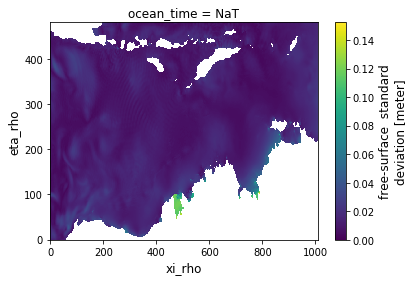

In [55]:
dsout = xr.open_dataset(outfile)

plt.figure()
dsout['zeta'].plot()

In [56]:
dsout.close()